In [1]:
# Importing the Modules
from scripts.py_functions  import list_datasets, plot_selection, nclones_report, read_json
import os

In [2]:
# Listing the existing datasets in the output folder
datasets_input = list_datasets()

8 datasets found in output\r_datar_data:
all_tp1_[2025-11-27_18-49-50]_baseline_values.csv
all_tp2_[2025-11-27_18-49-50]_baseline_values.csv
all_tp4_[2025-11-27_18-49-50]_baseline_values.csv
all_tpall_[2025-11-27_17-05-32]_baseline_values.csv
motif_tp1_[2025-11-27_20-15-00]_baseline_values.csv
motif_tp2_[2025-11-27_20-15-00]_baseline_values.csv
motif_tp4_[2025-11-27_20-15-00]_baseline_values.csv
motif_tpall_[2025-11-27_19-55-53]_baseline_values.csv


In [3]:
for input_file in os.listdir(read_json()["input_folder"]):
    print(f"Number of clones per grouped by sub-dataset for {input_file} input sequences:")
    temp_nclones = nclones_report(input_file)
    print(temp_nclones.groupby_count(read_json()["metadata_list"].split(",")), "\n")


Number of clones per grouped by sub-dataset for cl_seqs_all.csv input sequences:
  subject_id ab_target  unique_clones  seq_count
0     subj_3        sn          11490      14539
1     subj_3        sp           1567      20661
2     subj_4        sn          18713      33001
3     subj_4        sp            683       7631
4     subj_5        sn          17425      23803
5     subj_5        sp           3665      16845
6     subj_6        sn           8781      13829
7     subj_6        sp            630      14386
8     subj_7        sn           5546      17217
9     subj_7        sp            129       2315 

Number of clones per grouped by sub-dataset for cl_seqs_motif.csv input sequences:
  subject_id ab_target  unique_clones  seq_count
0     subj_3        sn            901       1010
1     subj_3        sp            260       2210
2     subj_4        sn           1090       1350
3     subj_4        sp            115        902
4     subj_5        sn           1267       1516
5

1
1
1
1
1
1
1
1


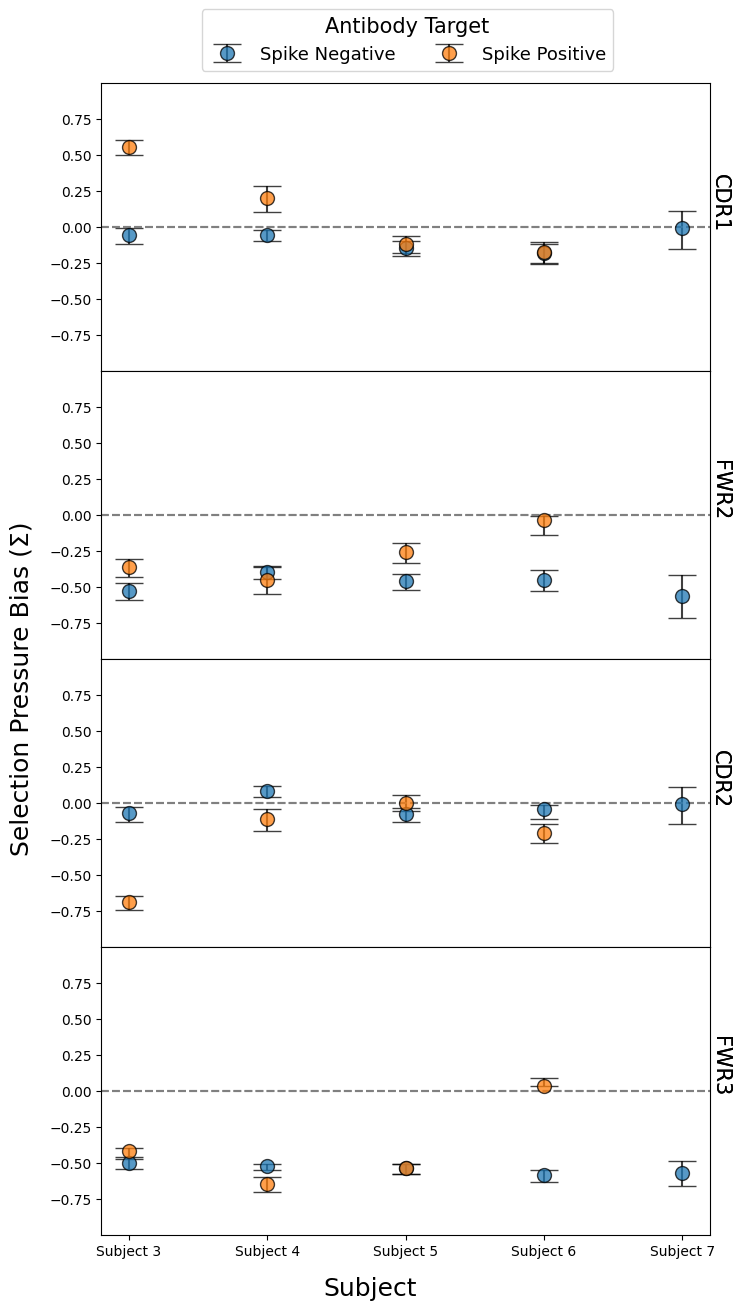

1
1
1
1
1
1
1
1


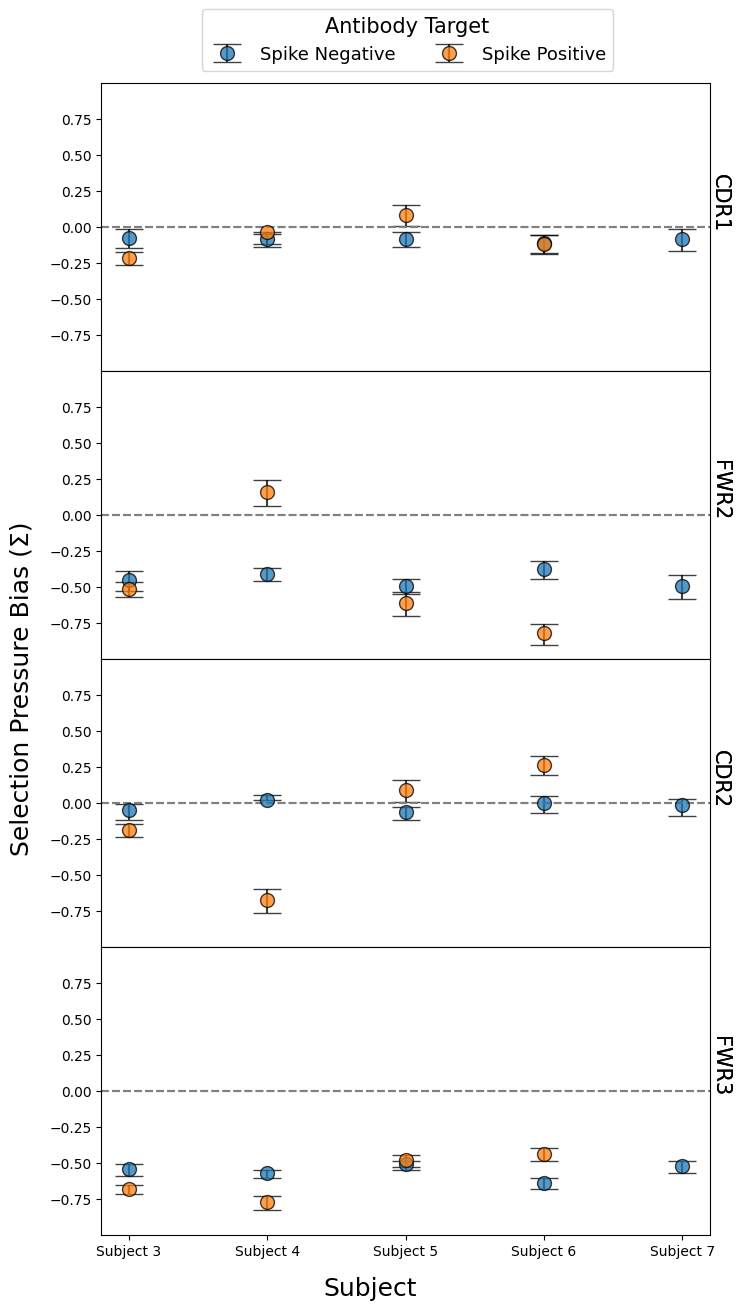

1
1
1
1
1
1
1
1


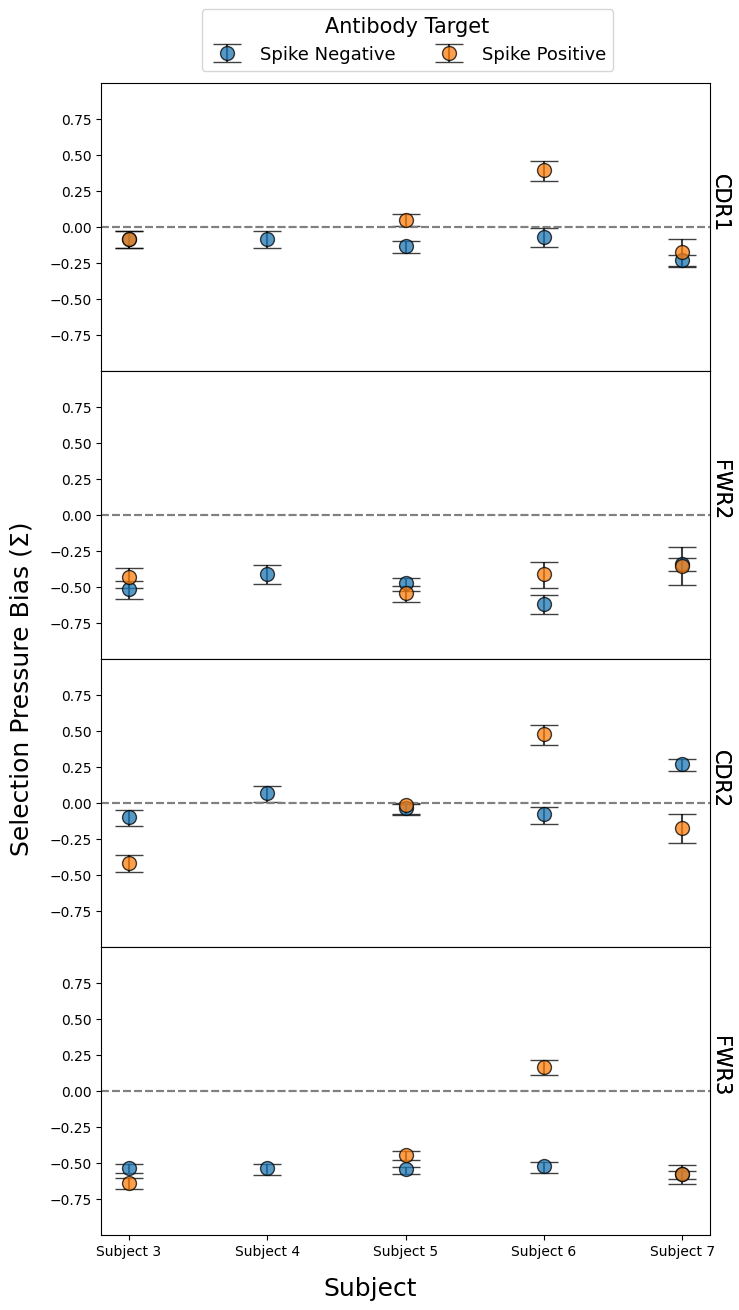

1
1
1
1
1
1
1
1


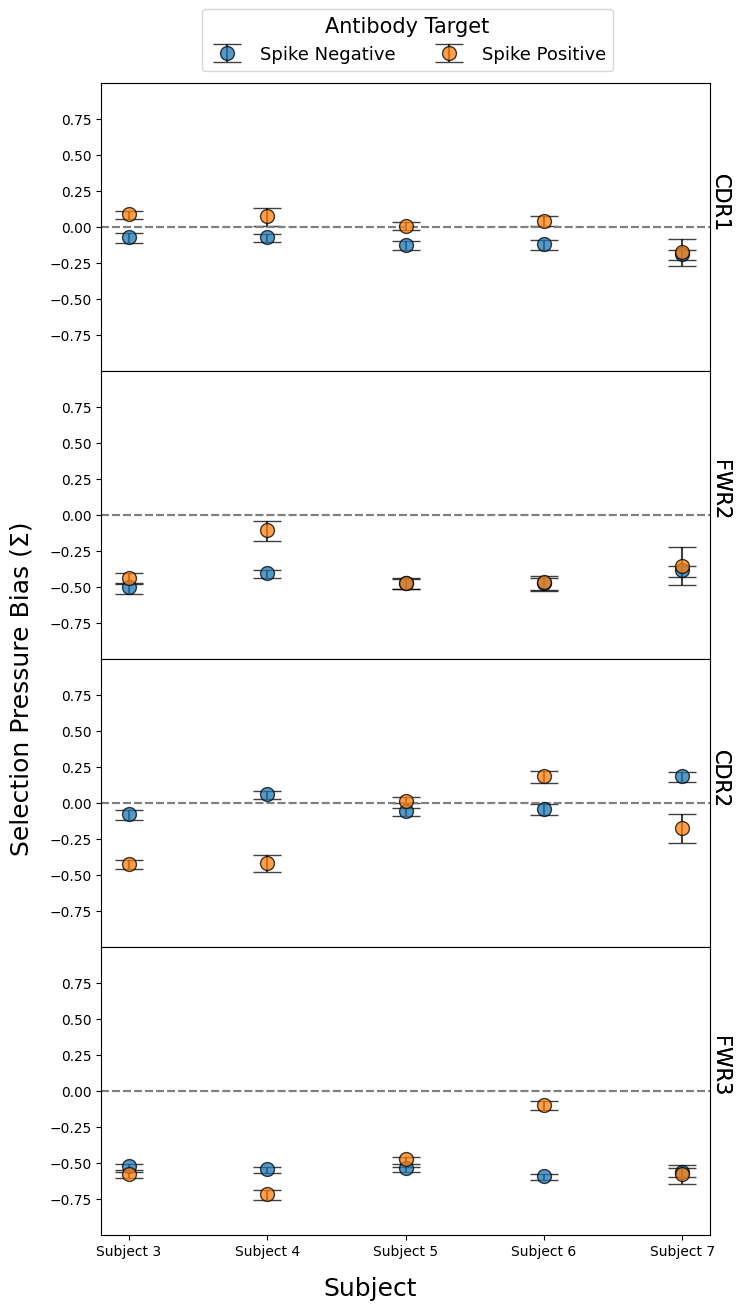

1.5
1.5
1.5
1.5
1.5
1.5
1.5
1.5


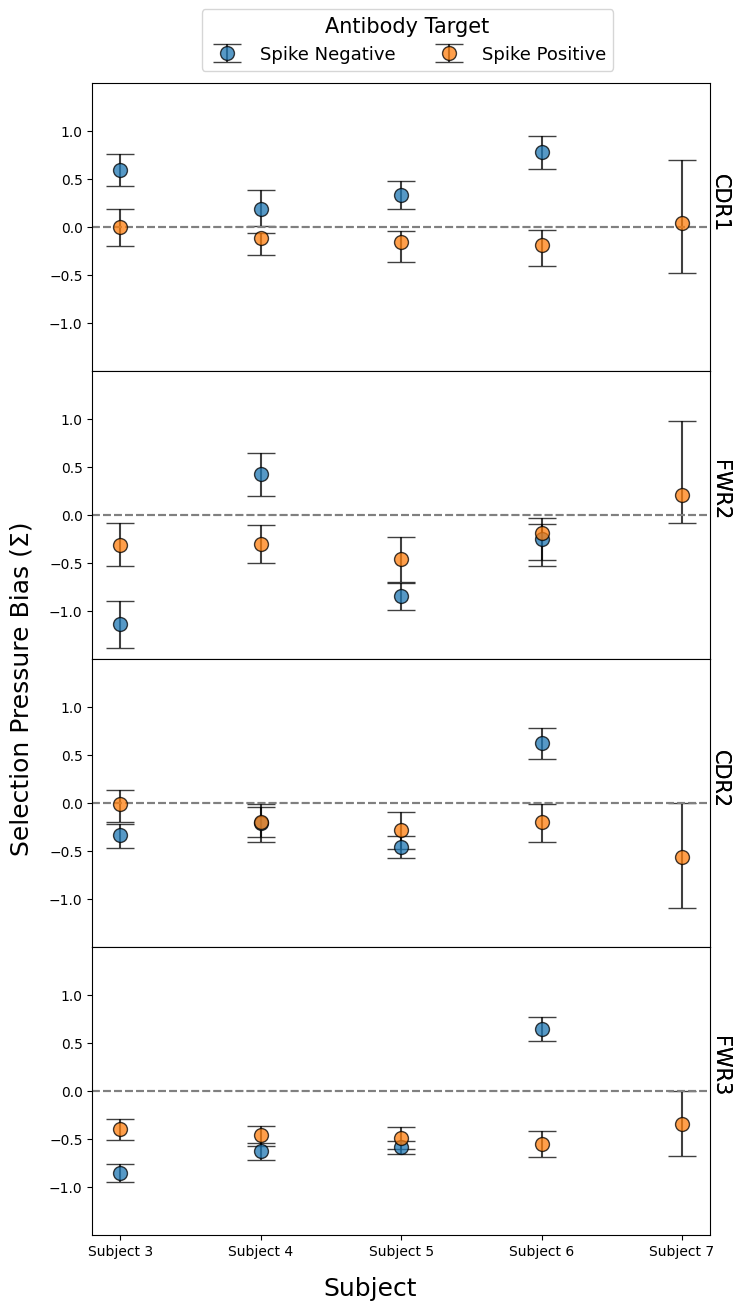

3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0


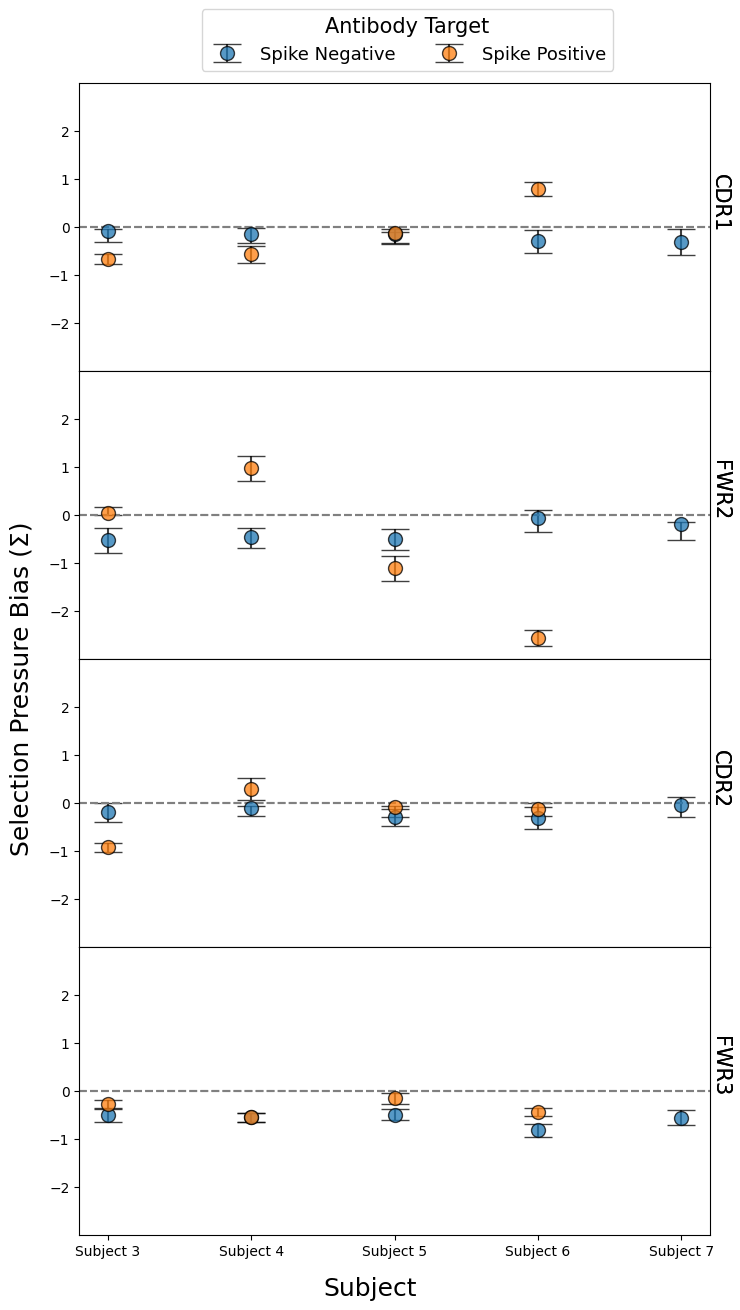

2.4
2.4
2.4
2.4
2.4
2.4
2.4
2.4


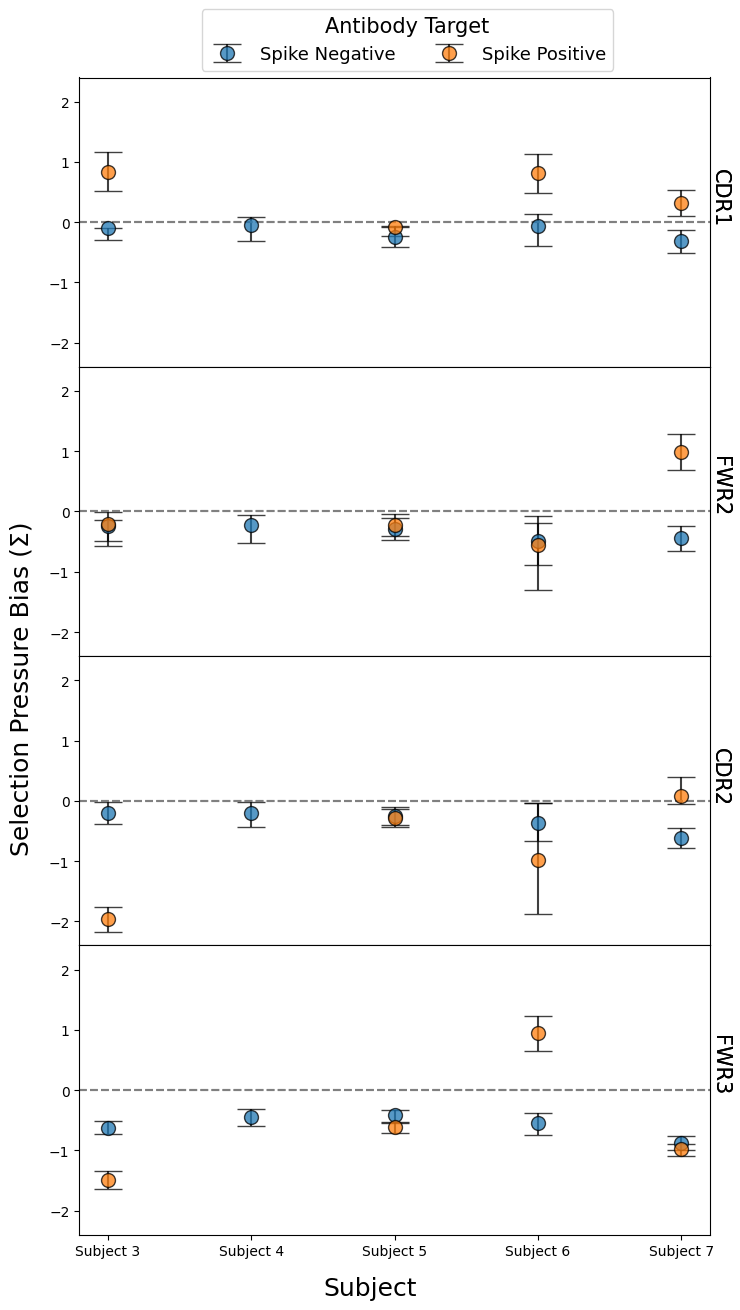

2.2
2.2
2.2
2.2
2.2
2.2
2.2
2.2


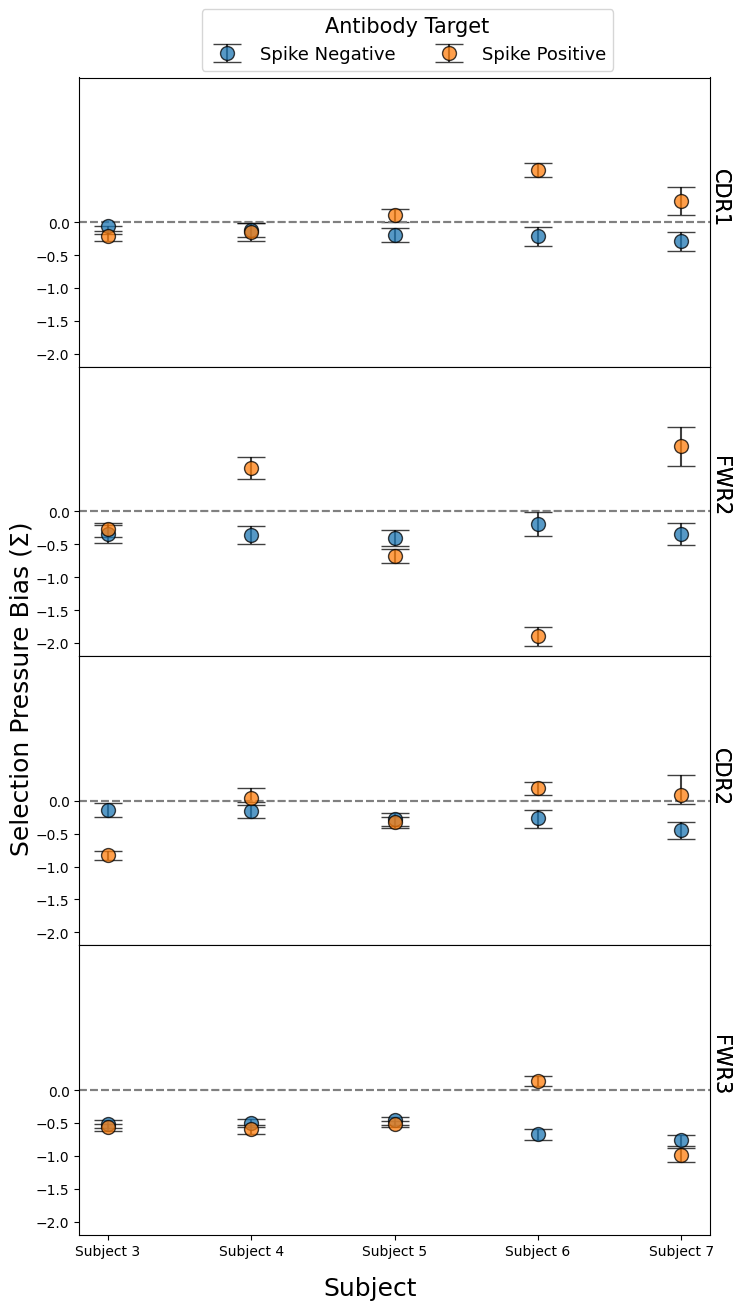

In [4]:
# Plotting figure of each dataset
for dt in datasets_input:
    plot_selection(dataset_path=dt,
                    metadata_split="Antibody Target",
                    save_fig=False)